# Variational Auto Encoder Pytorch Implementation for MNSIT 

First we import the required packages.

In [14]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from mpl_toolkits.axes_grid1 import ImageGrid
from torchvision.utils import save_image, make_grid
from torch.optim import Adam
from sklearn.manifold import  TSNE
from sklearn.decomposition import PCA


# Expermimental Set Up
The model we chosse is quite simple. We are using only linear layers with the ReLU activation function. 

In [15]:
config = {
    'model_name': 'VAE',
    'dataset': 'MNIST',
    # Variance and Mean for the weight initialization
    'weight_var': 1,
    'weight_mean': 0,
    'seed': 4,
    # Model setup 
    'input_dim': 784,
    'dims': [256, 128, 64, 16],
    'distribution_dim': 16,
    # Training setup
    'batch_size': 128,
    'num_epochs': 10,
    'learning_rate': 0.0002,
    'latent_dim': 16
}

# DEVICE for Mac for Windows use CUDA
DEVICE = torch.device("mps")
print(DEVICE)

# Set the seed
torch.manual_seed(config['seed'])

mps


# Load Dataset 
We agreed using the MNSIT dataset first. The code is loaded from the helper folder

In [4]:
import os
# Print the current working directory
print(os.getcwd())
# Set the working directory

# Change directory
os.chdir('/Users/mariotuci/Desktop/Google-Drive/Master/SoSe-24/Project Studies/Project/Code/latent-communication')
# Import MNIST Data Loader 
from helper.DataLoaderMNIST import DataLoader_MNIST

# Data Transformations
transformations = [transforms.ToTensor(), 
                                # Normalize between -1 and 1
                                transforms.Normalize((0.5,), (0.5,)),
                                # Flatten the Image to a vector
                                transforms.Lambda(lambda x: x.view(-1) )
                                ]
# Create DataLoader
dataloader = DataLoader_MNIST(config['batch_size'], transformations)

test_loader = dataloader.get_test_loader()
train_loader = dataloader.get_train_loader()

print(len(train_loader), len(test_loader))






/Users/mariotuci/Desktop/Google-Drive/Master/SoSe-24/Project Studies/Project/Code/latent-communication/helper
469 79


# Inisghts in the data
Always good to take a climpse at data before starting

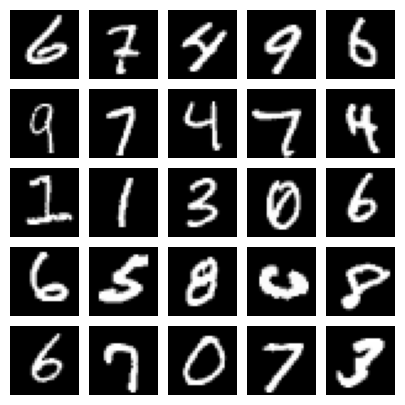

In [5]:
# get 25 sample training images for visualization
dataiter = iter(train_loader)
image = next(dataiter)
# Change the shape of the image (Flatten to 2D)
image_org = image[0].view(-1, 1, 28, 28)

num_samples = 25
sample_images = [image_org[i,0] for i in range(num_samples)] 

fig = plt.figure(figsize=(5, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(5, 5), axes_pad=0.1)

for ax, im in zip(grid, sample_images):
    ax.imshow(im, cmap='gray')
    ax.axis('off')

plt.show()

# Model VAE  


In [6]:
# Model comes from python file for later usage 
# Model is defined in model_def.py
from model_def import VAE
model = VAE(in_dim=784, dims=config['dims'], distribution_dim=config['distribution_dim']).to(DEVICE)

# Training Loop


In [197]:
# Device 
#Devive = torch.device("cuda" if torch.cuda.is_available() else "cpu")

optimizer = Adam(model.parameters(), lr=config['learning_rate'])
# Initialize the optimizer
print("Start training VAE...")
model.train()

for epoch in range(config['num_epochs']):
    overall_loss = 0
    for batch_idx, (x, _) in enumerate(train_loader):
        #x = x.view(config['batch_size'], config['input_dim'])
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, mean, log_var = model(x)
        loss = model.loss_function(x, x_hat, mean, log_var)
        
        overall_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    print("\tEpoch", epoch + 1, "complete!", "\tAverage Loss: ", overall_loss / (batch_idx*batch_size))
    
print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Loss:  237.4304209000025
	Epoch 2 complete! 	Average Loss:  185.7032700889131
	Epoch 3 complete! 	Average Loss:  169.42410596211752
	Epoch 4 complete! 	Average Loss:  152.5637109381521
	Epoch 5 complete! 	Average Loss:  138.30568615187946
	Epoch 6 complete! 	Average Loss:  129.89211058005307
	Epoch 7 complete! 	Average Loss:  123.6041075714633
	Epoch 8 complete! 	Average Loss:  117.11822424994574
	Epoch 9 complete! 	Average Loss:  113.41631349742921
	Epoch 10 complete! 	Average Loss:  110.69752898583046
Finish!!


# Safe the model 
In this case we are using the follwing name convention Dataset_ModelName_Seed_Epochs. 

In [198]:
# Save the model
name = config['dataset']+ '_' + config['model_name'] + '_' + str(config['seed']) + '_' + str(config['num_epochs']) + '.pth'
print(name)
# Model Path
path = './models/' + name

torch.save(model.state_dict(), path)

MNIST_VAE_4_10.pth


# Sample Pictures
In the next Code Snippet we sample directly from the latent space and decode the picture. 

In [199]:
# Sample from the model
name_pic_sample = config['dataset']+ '_' + config['model_name'] + '_' + str(config['seed']) + '_' + str(config['num_epochs']) + '_' + 'sample' +'.png'
path_pic_sample = './figures/' + name_pic_sample

with torch.no_grad():
    z = torch.randn(25, config['distribution_dim']).to(DEVICE)
    sample = model.decode(z).cpu()
    save_image(sample.view(25, 1, 28, 28), path_pic_sample)

# Get Reconstruction Results

In [200]:
# Reconstruction
dataiter = iter(train_loader)
images, labels = next(dataiter)
# Get 5 images
images = images[:25]
images = images.to(DEVICE)
images = images.view(images.size(0), -1)
name_pic = config['dataset']+ '_' + config['model_name'] + '_' + str(config['seed']) + '_' + str(config['num_epochs']) + '_reconstruction.png'
path = './figures/' + name_pic
with torch.no_grad():
    # Get Sample from the model
    images_hat, _, _ = model(images)
    images_hat = images_hat.view(images.size(0), 1, 28, 28)
    comparison = torch.cat([images.view(-1, 1, 28, 28), images_hat.view(-1, 1, 28, 28)])
    save_image(comparison.cpu(),path, nrow=images.size(0))


# Plot Latent


(60000, 32)
(60000,)


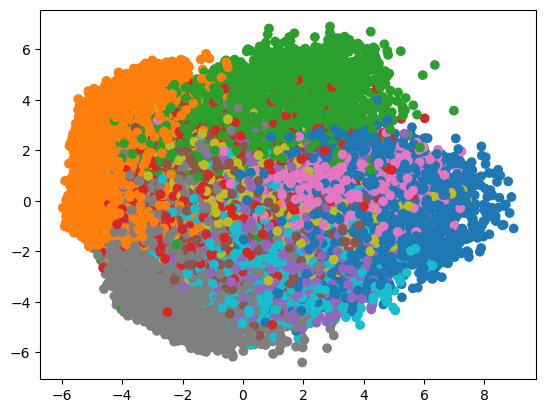

In [201]:
# Latent Space
latent_spaces = []
all_labels = []

# Iterate through all batches in train_loader
for images, labels in train_loader:
    images = images.to(DEVICE)
    images = images.view(images.size(0), -1)
    latent_space = model.getLatenSpace(images)
    latent_spaces.append(latent_space.cpu().detach().numpy())
    all_labels.append(labels.numpy())

# Concatenate latent space representations from all batches
latent_space = np.concatenate(latent_spaces, axis=0)
all_labels = np.concatenate(all_labels, axis=0)

print(latent_space.shape)
print(all_labels.shape)

# Plot latent space via PCA
pca = PCA(n_components=2)
latent_space_pca = pca.fit_transform(latent_space)

# Plot the latent space
plot = plt.scatter(latent_space_pca[:, 0], latent_space_pca[:, 1], c=all_labels, cmap='tab10', label=all_labels)
plt.show(plot)

# Save the plot
name = config['dataset']+ '_' + config['model_name'] + '_' + str(config['seed']) + '_' + str(config['num_epochs']) + '_PCA.png'
path = './figures/' + name

plot.figure.savefig(path)



